In [1]:
import numpy as np 
import pandas as pd
import geopandas as gpd
import shapely
from shapely.wkt import loads
import shapely.vectorized as sv 
from scipy.spatial.distance import cdist 

In [2]:
nodes_df = pd.read_csv('../network_inputs/osm_nodes.csv')
nodes_gdf = gpd.GeoDataFrame(nodes_df, geometry=[shapely.geometry.Point(xy) for xy in zip(nodes_df.lon, nodes_df.lat)], crs='epsg:4326')
print(nodes_gdf.head())
visitor_nodes_df = pd.read_csv('../network_inputs/osm_nodes_visitor_parking.csv')
visitor_nodes_gdf = gpd.GeoDataFrame(visitor_nodes_df, geometry=[shapely.geometry.Point(xy) for xy in zip(visitor_nodes_df.lon, visitor_nodes_df.lat)], crs='epsg:4326')
print(visitor_nodes_gdf.head())

   node_id_igraph  node_osmid         lon        lat signal  \
0               0   110418187 -122.649946  37.902311    NaN   
1               1   110392834 -122.711450  37.901207    NaN   
2               2   110460422 -122.701883  37.903178    NaN   
3               3   110460424 -122.698763  37.899716    NaN   
4               4   110397449 -122.637744  37.898467    NaN   

                      geometry  
0  POINT (-122.64995 37.90231)  
1  POINT (-122.71145 37.90121)  
2  POINT (-122.70188 37.90318)  
3  POINT (-122.69876 37.89972)  
4  POINT (-122.63774 37.89847)  
   node_id_igraph  node_osmid         lon        lat signal  \
0               7   110421520 -122.686998  37.906398    NaN   
1              11   110421540 -122.687898  37.904398    NaN   
2              16   110366250 -122.685282  37.905177    NaN   
3              17   110421553 -122.690031  37.904410    NaN   
4              18   110421555 -122.691044  37.903766    NaN   

                      geometry  
0  POINT (-

In [8]:
### Get the OSMid of the closest node to each parcel
bolinas_parcels = pd.read_csv('parcels/parcels_bolinas/parcels_bolinas.csv')
household_parcels = bolinas_parcels[bolinas_parcels['UseCd']==11].reset_index() ### only UseCd 11 has household size>0 (=1)
household_parcels = gpd.GeoDataFrame(household_parcels, crs='epsg:4326',
                                     geometry=household_parcels['WKT'].apply(loads))
print(household_parcels.shape)

household_parcels['centroid'] = household_parcels.apply(lambda x: x['geometry'].centroid, axis=1)
household_parcels = household_parcels.set_geometry('centroid')
household_parcels['c_x'] = household_parcels['centroid'].x
household_parcels['c_y'] = household_parcels['centroid'].y
nodes_xy = np.array([nodes_gdf['geometry'].x.values, nodes_gdf['geometry'].y.values]).transpose()
nodes_osmid = nodes_gdf['node_osmid'].values

def get_closest_node(parcel_x, parcel_y):
    return nodes_osmid[cdist([(parcel_x, parcel_y)], nodes_xy).argmin()]

household_parcels['closest_node'] = household_parcels.apply(lambda x: get_closest_node(x['c_x'], x['c_y']), axis=1)
print(household_parcels.head())
household_parcels.shape
# parcels_evac.to_csv(absolute_path+'/outputs/parcels_evac.csv', index=False)

(595, 12)
   index                                                WKT  \
0      7  POLYGON ((-122.705885636748 37.9437779330562,-...   
1      8  POLYGON ((-122.705569630863 37.9429819296033,-...   
2      9  POLYGON ((-122.70497783629 37.9414082901364,-1...   
3     11  POLYGON ((-122.706323476 37.9451771536848,-122...   
4     12  POLYGON ((-122.707857752019 37.9455569646437,-...   

                                               WKT.1  Acres  UseCd  \
0  MULTIPOLYGON (((-122.705885636748 37.943777933...  0.504     11   
1  MULTIPOLYGON (((-122.705569630863 37.942981929...  2.124     11   
2  MULTIPOLYGON (((-122.70497783629 37.9414082901...  0.344     11   
3  MULTIPOLYGON (((-122.706323476 37.945177153684...  4.146     11   
4  MULTIPOLYGON (((-122.707857752019 37.945556964...  3.934     11   

                  UseCdDesc    Parcel          AssessorSi     SHAPE_STAr  \
0  Single-Resid. - Improved  18810004  5855 STATE ROUTE 1   21985.887695   
1  Single-Resid. - Improved  18810005 

(595, 16)

In [18]:
local_comm_dict = {
    0: {'comm_nm': 'fire_radio', 'pct_pop': [5, 5, 5], 'info_rate': [150, 150, 150]},
    1: {'comm_nm': 'ham_radio', 'pct_pop': [5, 5, 5], 'info_rate': [150, 150, 150]},
    2: {'comm_nm': 'social_media', 'pct_pop': [20, 10, 0], 'info_rate': [300, 150, 0]},
    3: {'comm_nm': 'code_red', 'pct_pop': [5, 5, 0], 'info_rate': [30, 15, 0]},
    4: {'comm_nm': 'cell_phone', 'pct_pop': [30, 15, 0], 'info_rate': [45, 22.5, 0]},
    5: {'comm_nm': 'door_to_door', 'pct_pop': [5, 30, 60], 'info_rate': [2.5, 2.5, 2.5]},
    100: {'comm_nm': 'none', 'pct_pop': [30, 30, 30], 'info_rate': [0, 0, 0]}}
visitor_comm_dict = {
    2: {'comm_nm': 'social_media', 'pct_pop': [50, 25, 0], 'info_rate': [300, 150, 0]},
    3: {'comm_nm': 'code_red', 'pct_pop': [25, 12.5, 0], 'info_rate': [30, 15, 0]},
    4: {'comm_nm': 'cell_phone', 'pct_pop': [25, 12.5, 0], 'info_rate': [45, 22.5, 0]},
    100: {'comm_nm': 'none', 'pct_pop': [0, 50, 100], 'info_rate': [0, 0, 0]}}

commscen_id = 2
random_seed = 0
np.random.seed(random_seed)
vphh = 2

def assign_depttime(x, d):
    rate = d[x['comm']]['info_rate'][commscen_id]/60
    if rate == 0:
        return 1e6
    else:
        scale = 1/rate
        return np.random.gamma(x['event_cnt'], scale=scale)

### local residents origin
local_residents_origin = household_parcels['closest_node'].values.tolist()
# Comm method trigger evacuation (not considering sight)
local_residents_comm = np.random.choice([k for k in local_comm_dict.keys()], 
                                        p=[v['pct_pop'][commscen_id]/100 for v in local_comm_dict.values()],
                                        size=len(local_residents_origin))
local_residents_od_df = pd.DataFrame({'parcel': household_parcels['Parcel'].values.tolist(), 'origin_osmid': local_residents_origin, 'comm': local_residents_comm})
local_residents_od_df = local_residents_od_df.sample(frac=1).reset_index(drop=True)
local_residents_od_df['event_cnt'] = local_residents_od_df.groupby('comm').cumcount()
local_residents_od_df['dept_time'] = local_residents_od_df.apply(lambda x: assign_depttime(x, local_comm_dict), axis=1)
local_residents_od_df['type'] = 'local'


### visitor origin
visitor_cnts = 300 ### 500 vehicles
visitor_vehicle_origin = np.random.choice(visitor_nodes_gdf['node_osmid'], size=visitor_cnts)
visitor_vehicle_comm = np.random.choice([k for k in visitor_comm_dict.keys()], 
                                        p=[v['pct_pop'][commscen_id]/100 for v in visitor_comm_dict.values()],
                                        size=len(visitor_vehicle_origin))
visitor_vehicle_od_df = pd.DataFrame({'origin_osmid': visitor_vehicle_origin, 'comm': visitor_vehicle_comm})
visitor_vehicle_od_df = visitor_vehicle_od_df.sample(frac=1).reset_index(drop=True)
visitor_vehicle_od_df['event_cnt'] = visitor_vehicle_od_df.groupby('comm').cumcount()
visitor_vehicle_od_df['dept_time'] = visitor_vehicle_od_df.apply(lambda x: assign_depttime(x, visitor_comm_dict), axis=1)
visitor_vehicle_od_df['type'] = 'visitor'
visitor_vehicle_od_df['parcel'] = None
od_df = pd.concat([local_residents_od_df]*vphh+[visitor_vehicle_od_df])
od_df['dept_time'] = np.round(od_df['dept_time'],0)
od_df['destin_osmid'] = np.random.choice(['110360959', '110397253'], size=od_df.shape[0])
od_df.to_csv('od_csv/resident_visitor_od_rs{}_commscen{}_vphh{}_visitor{}.csv'.format(random_seed, commscen_id, vphh, visitor_cnts), index=False)

0.19111111111111112


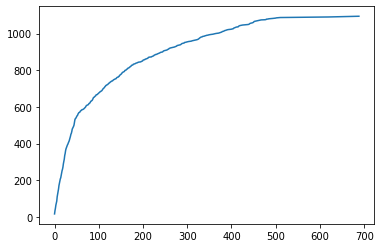

In [71]:
import matplotlib.pyplot as plt
print(np.max(od_df['dept_time'])/3600)
od_plot = od_df.dropna(subset=['dept_time']).groupby('dept_time').size().reset_index().rename(columns={0:'dept_cnts'})
plt.plot(od_plot['dept_time'], od_plot['dept_cnts'].cumsum())